In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

run = 5
output_dir = 'outputs'

## Main Functions

In [2]:
def display_img(img, title="Store Map", figsize=(15, 10), cmap='gray', minmax=True):
    plt.figure(figsize=figsize)
    if minmax:
        plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

def generate_board(width, height):
    img = np.ones((width, height))
    for i in range(1, width-1):
        for j in range(1, height-1):
            img[i, j] = np.random.rand() > 0.5
    for i in range(1, width-1):
        for j in range(1, height-1):
            sumAround = 0
            for m in range(i-1, i+2):
                for n in range(j-1, j+2):
                    if (m != n):
                        sumAround += img[m, n]
            if sumAround > 4:
                img[i, j] = 1
    return img

def get_section(img_map, w, h):
    if img_map.shape[0] - h > 0:
        start_x = np.random.randint(img_map.shape[0] - h)
    else:
        start_x = 0
    if img_map.shape[1] - w > 0:
        start_y = np.random.randint(img_map.shape[1] - w)
    else:
        start_y = 0
    return img_map[start_x:start_x+h, start_y:start_y+w]

def create_targets(num, img_map):
    h, w = img_map.shape
    points = []
    for i in range(0, num):
        x = np.random.randint(h)
        y = np.random.randint(w)
        while img_map[x, y] > 0:
            x = np.random.randint(h)
            y = np.random.randint(w)
        points.append((x, y))
    return np.array(points)

def lerp(a, b, x):
    return a + x * (b - a)

def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def perlin(x, y, seed=0):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    u = fade(xf)
    v = fade(yf)
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

def generate_noise_image(width, height, origin=0, scale_factor=5, seed=2):
    size = max([width, height])
    scale_x = width / size
    scale_y = height / size
    X = np.linspace(origin, scale_factor * scale_x, width, endpoint=False)
    Y = np.linspace(origin, scale_factor * scale_y, height, endpoint=False)
    x, y = np.meshgrid(X, Y)
    noise_img = perlin(x, y, seed=seed)
    return noise_img

## Generate Random Targets

Here we load the provided collision map, create a set of 50 random targets and display them

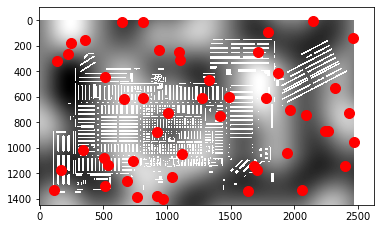

In [3]:
collision_map = np.load('./collision_map.npy')
h, w = collision_map.shape
num_targets = 50
noise_seed = 40
section = get_section(collision_map, w, h)
targets = create_targets(num_targets, section)

noise_img = generate_noise_image(w, h, seed=noise_seed)
noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))

travel_friction = (~section>0).astype(int) * noise_img
travel_friction[section>0] = np.inf
for x, y in targets:
    travel_friction[x][y] = 0

fig, ax = plt.subplots()
ax.imshow(travel_friction*255, cmap='gray')
target_plot = [[y for _, y in targets], [x for x, _ in targets]]
ax.scatter(*target_plot, s=100, color='red')

## Cost Functions

In order to find the optimal order of targets, we need to first describe a cost function. We define two basic cost methods here, Manhattan and Euclidean. In order to estimate the time between two points, we will analyze the two Manhattan distances between the points and the diagonal Euclidean distance. For each of these distances, we will also create a filter that can be used to obtain the friction and obstacles between the points.

In [4]:
def get_manhattan(p1, p2):
    return abs((p1[0] - p2[0])) + abs((p1[1] - p2[1]))
def get_euclidean(p1, p2):
    return np.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )
def get_manhattan_filters(p1, p2, w, h):
    f1 = np.zeros((h, w))
    f2 = np.zeros((h, w))
    xmin = min(p1[0], p2[0])
    xmax = max(p1[0], p2[0]) + 1
    ymin = min(p1[1], p2[1])
    ymax = max(p1[1], p2[1]) + 1
    f1[xmin:, p2[1]] = 1
    f2[xmin:, p1[1]] = 1
    f1[p1[0], ymin:] = 1
    f2[p2[0], ymin:] = 1
    f1[xmax:, :] = 0
    f2[xmax:, :] = 0
    f1[:, ymax:] = 0
    f2[:, ymax:] = 0
    return f1, f2
def get_euclidean_filter(p1, p2, w, h):
    f = np.zeros((h, w))
    x_dir = np.sign(p2[0] - p1[0])
    y_dir = np.sign(p2[1] - p1[1])
    x, y = p1
    f[x, y] = 1
    while (x, y) != (p2[0], p2[1]):
        if abs(p2[0] - x) > abs(p2[1] - y):
            x += x_dir * 1
        else:
            y += y_dir * 1
        f[x, y] = 1
    f[p2[0], p2[1]] = 1
    return f

We will define distance as
$$d_{cost} = \min_{k = m_1, m_2, e} \biggl[ d_k + \alpha \sum_{i, j} (f_k \circ F_{map})_{ij} \biggr] $$
where $d_k$ is the actual distance, $f_k$ is the filter, $F_{map}$ is the friction map and $\circ$ is the Hadamond product. $\alpha$ is a tuneable parameter that represents the weight given to the friction term of $d_{cost}$. After the three cost methods are computed, we take the minimum where $m_1$ and $m_2$ are the Manhattan costs, and $e$ is the Euclidean cost. Because of how the distance matrix is arranged, it is guaranteed to be symmetric across the main diagonal, therefore we compute the lower half and add the transpose to avoid doing redundant calculations.

In [ ]:
def get_distance(targets):
    distance = np.zeros((num_targets, num_targets))
    alpha = 0.3
    for i in range(0, num_targets):
        for j in range(0, num_targets):
            if (i == j):
                continue
            if i > j:
                continue
            p1, p2 = targets[i], targets[j]
            #f1, f2 = get_manhattan_filters(p1, p2, w, h)
            (f1, f2), f3 = get_manhattan_filters(p1, p2, w, h), get_euclidean_filter(p1, p2, w, h)
            manhattan = get_manhattan(p1, p2)
            euclidean = get_euclidean(p1, p2)
            d1 = manhattan + alpha * np.sum(f1 * (section/255))
            d2 = manhattan + alpha * np.sum(f2 * (section/255))
            d3 = euclidean + alpha * np.sum(f3 * (section/255))
            distance[i, j] = np.min([d1, d2, d3])
            #distance[i, j] = np.min([d1, d2])
    distance = distance + distance.T
    return distance
distance = get_distance(targets)

We are using Google's ortools package to determine the optimal route. This algorithm uses a distance matrix with indices (i, j) such that `distance_matrix[i][j]` represents the distance from point i to point j. More information on this package can be found at https://developers.google.com/optimization/routing/tsp

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [ ]:
def print_solution(manager, routing, assignment):
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    
def get_solution(manager, routing, assignment, start):
    index = routing.Start(start)
    plan = [0]
    while not routing.IsEnd(index):
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        plan.append(index)
    return plan[:-1]

`get_target_order` returns an array that contains the optimal order of targets

In [ ]:
def create_distance_callback(distance, manager):
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance[from_node][to_node]
    return distance_callback

def get_target_order(distance, starting_pos):
    manager = pywrapcp.RoutingIndexManager(len(distance), 1, starting_pos)
    routing = pywrapcp.RoutingModel(manager)
    distance_callback = create_distance_callback(distance, manager)
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    target_order = get_solution(manager, routing, assignment, 0)
    return target_order
target_order = get_target_order(distance, 0)

Here we run our algorithm and plot the points labeled with their corresponding order

In [ ]:
fig, ax = plt.subplots()
ax.imshow(travel_friction*254, cmap='gray')
target_plot = [[y for _, y in targets], [x for x, _ in targets]]
ax.scatter(*target_plot, s=100, color='red')
for i in range(0, num_targets):
    ax.annotate(
        np.where(np.array(target_order) == i)[0][0] + 1, 
        (target_plot[0][i], target_plot[1][i]), color='lime')

### Product Placement

To get the best product placement, we have formed a two-part algorithm. First, we randomly place targets on a friction map using the pixel values of the map to create a probability distribution for the sampling. In order to avoid high friction areas, we set any pixel with friction greater than 0.5 to 0. After placing the targets, we calculate the best route using the above algorithm using every target such that $n$ targets will lead to $n$ distances using our $d_{cost}$ formula. We take the mean of these $d_{cost}$ values and use that as the final cost of that target placement. We assume that over enough trials, this would lead to the optimal product placement.

In [ ]:
def get_cood(shape):
    w, h = shape
    cood = []
    for j in range(w):
        for i in range(h):
            cood.append((j, i))
    return np.array(cood)
            
def get_weighted_targets(friction_map):
    p = np.ones(friction_map.shape) - friction_map
    p[p < 0.5] = 0
    p /= p.sum()
    cood = get_cood(friction_map.shape)
    p = p.reshape(-1)
    idx = np.random.choice(range(len(cood)), size=num_targets, p=p)
    return cood[idx]
w_targets = get_weighted_targets(noise_img)

In [ ]:
def get_cust_dist(distance, start_pos):
    target_order = get_target_order(distance, start_pos)
    tot_dist = 0
    for i in range(0, len(target_order) - 1):
        tot_dist += distance[target_order[i], target_order[i+1]]
    return tot_dist

def run_trial(friction_map):
    tgts = get_weighted_targets(friction_map)
    distance = get_distance(tgts)
    scores = []
    for i in range(num_targets):
        scores.append(get_cust_dist(distance, i))
    score = np.array(scores).mean()
    return tgts, score

In [ ]:
results = {
    'targets_x': [],
    'targets_y': [],
    'scores': []
}
# Was ran on HPRC cluster
num_iters = 0
for i in range(num_iters):
    print('workin on ' + str(i) + '...')
    tgts, score = run_trial(noise_img)
    for x, y in zip(tgts[:, 0], tgts[:, 1]):
        results['targets_x'].append(x)
        results['targets_y'].append(y)
        results['scores'].append(score)
result_df = pd.DataFrame(results)
result_df.head()
result_df.to_csv(output_dirF + '/output_' + run + '.csv')

Importing results from HPRC run

In [ ]:
df = pd.read_csv('./final_outputs/output_15.csv')
tgts = [(x, y) for x, y in zip(df['targets_x'], df['targets_y'])]

Plotting the product placements, we see that our algorithm chose low traffic areas for the products, and distributed them evenly enough such that they do not cause traffic jams due to their placements

In [ ]:
plt.imshow(travel_friction*255, cmap='gray')
plt.scatter([y for _, y in tgts], [x for x, _ in tgts], color='red')